In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from sklearn.linear_model import LinearRegression

Collect and preprocessing the data

In [2]:
gefcom = pd.read_csv("Data/GEFCOM_fixed.txt", sep="\s+", names = ["Date", "Hour", "Price", "System_load", "Zonal_load", "Day_of_week"])

<>:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_6671/2169693869.py:1: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  gefcom = pd.read_csv("Data/GEFCOM_fixed.txt", sep="\s+", names = ["Date", "Hour", "Price", "System_load", "Zonal_load", "Day_of_week"])


In [3]:
# Check variables types
gefcom.dtypes

Date           float64
Hour           float64
Price          float64
System_load    float64
Zonal_load     float64
Day_of_week    float64
dtype: object

In [4]:
# Change Date column to datetime type
gefcom["Date"] = pd.to_datetime(gefcom["Date"], format="%Y%m%d").dt.date

In [5]:
gefcom.describe()

,Hour,Price,System_load,Zonal_load,Day_of_week
count,25968.00000,25968.000000,25968.000000,25968.000000,25968.000000
mean,11.50000,48.190072,18165.881200,6105.779767,4.000000
std,6.92232,26.179381,3453.664269,1309.476852,2.002348
min,0.00000,12.520000,11544.000000,3395.000000,1.000000
25%,5.75000,33.470000,15620.000000,5131.000000,2.000000
50%,11.50000,42.870000,18069.000000,6076.000000,4.000000
75%,17.25000,54.300000,19858.250000,6714.000000,6.000000
max,23.00000,363.800000,33449.000000,11441.000000,7.000000


In [ ]:
# Check NA values
gefcom.isna().sum()

Date           0
Hour           0
Price          0
System_load    0
Zonal_load     0
Day_of_week    0
dtype: int64

In [7]:
# Check for dupplicates 
gefcom.duplicated().sum()

np.int64(0)

In [8]:
# Check unique hours
gefcom["Hour"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [9]:
# Check if price for each record > 0
(gefcom["Price"] <= 0).sum()

np.int64(0)

In [10]:
# Create a new column with log price
gefcom["Log_price"] = np.log(gefcom["Price"])
gefcom

,Date,Hour,Price,System_load,Zonal_load,Day_of_week,Log_price
0,2011-01-01,0.0,43.17,15187.0,5091.0,6.0,3.765146
1,2011-01-01,1.0,36.24,14464.0,4918.0,6.0,3.590163
2,2011-01-01,2.0,34.64,13940.0,4763.0,6.0,3.545009
3,2011-01-01,3.0,33.76,13609.0,4660.0,6.0,3.519277
4,2011-01-01,4.0,33.08,13391.0,4599.0,6.0,3.498929
...,...,...,...,...,...,...,...
25963,2013-12-17,19.0,113.92,23091.0,7167.0,2.0,4.735496
25964,2013-12-17,20.0,107.26,22504.0,6958.0,2.0,4.675256
25965,2013-12-17,21.0,89.02,21538.0,6707.0,2.0,4.488861
25966,2013-12-17,22.0,85.40,20025.0,6316.0,2.0,4.447346


In [11]:
gefcom = gefcom.sort_values(["Date", "Hour"]).reset_index(drop=True)

# Model building

- ARX: 
$$p_{d,h} = \beta_{0} + \beta_{1p_{d-1,h}} + \beta_{2p_{d-2,h}} + \beta_{3p_{d-7,h}} + \beta_{4p_{min,d-1}} + \beta_{5z_{d}} + \sum \beta_{D} D_{d} + \epsilon_{d,h}$$

In [12]:
# Create log price lags
gefcom["p_lag1"] = gefcom.groupby("Hour")["Log_price"].shift(1)
gefcom["p_lag2"] = gefcom.groupby("Hour")["Log_price"].shift(2)
gefcom["p_lag7"] = gefcom.groupby("Hour")["Log_price"].shift(7)

# Set minimal log price from previous day 
daily_min = gefcom.groupby("Date")["Log_price"].min().shift(1)
gefcom = gefcom.merge(daily_min.rename("min_price"), on="Date")

# Create exogenic variable - log(System_load) 
daily_log_system_load = np.log(gefcom.groupby("Date")["System_load"].mean())
gefcom = gefcom.merge(daily_log_system_load.rename("Log_system_load"), on="Date")

print(gefcom.groupby("Date")["Log_system_load"].nunique().max()) # Check if log_system_load is constant within the day

# Create dummies
gefcom["D_1"] = (gefcom["Day_of_week"] == 1).astype(int)
gefcom["D_6"] = (gefcom["Day_of_week"] == 6).astype(int)
gefcom["D_7"] = (gefcom["Day_of_week"] == 7).astype(int)

print(gefcom.groupby("Date")["min_price"].nunique().max()) # Check if min_price is constant within the day

1
1


In [13]:
# Drop first 7 days of observation
gefcom = gefcom[7*24:].reset_index(drop=True)

In [ ]:
# Split the data to train and test 
## In the article: train: 2011-01-01 -> 2012-12-28, test: 2012-12-29 -> 2013-12-17
split_date = dt.date(2012,12,28)

/var/folders/kf/fpf7cl4d74g_zpz2l3v784zr0000gn/T/ipykernel_5933/1571021388.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


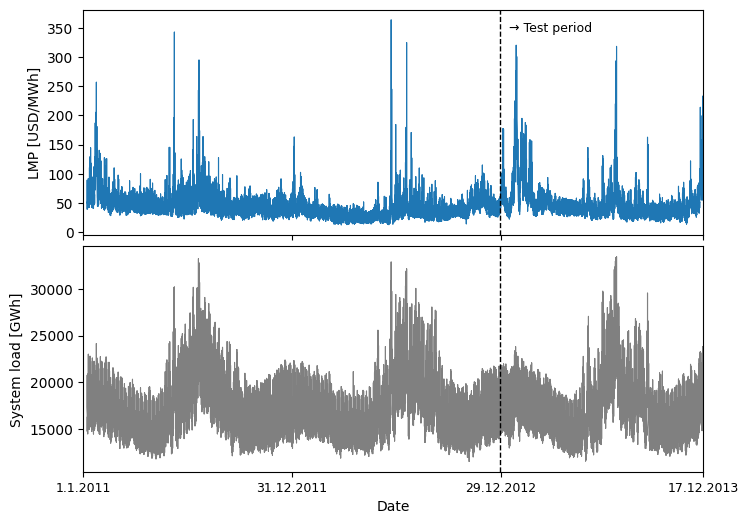

In [ ]:
# Define key dates
x_ticks = [
    dt.date(2011,1,1),
    dt.date(2011,12,31),
    dt.date(2012,12,29),
    dt.date(2013,12,17)
]
x_labels = ["1.1.2011", "31.12.2011", "29.12.2012", "17.12.2013"]

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'hspace': 0.05})

# --- Top panel: Prices
ax1.plot(gefcom["Date"], gefcom["Price"], color="tab:blue", linewidth=0.8)
ax1.set_ylabel("LMP [USD/MWh]", fontsize=10)

# --- Bottom panel: System Load
ax2.plot(gefcom["Date"], gefcom["System_load"], color="gray", linewidth=0.8)
ax2.set_ylabel("System load [GWh]", fontsize=10)
ax2.set_xlabel("Date", fontsize=10)

# --- Set x-axis limits to data range (no empty space)
xmin = gefcom["Date"].min()
xmax = gefcom["Date"].max()
ax1.set_xlim(xmin, xmax)

# --- Set x-axis ticks and labels
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_labels, fontsize=9)

# --- Add one continuous dashed vertical line for the test period
for ax in [ax1, ax2]:
    ax.axvline(split_date, color="k", linestyle="--", linewidth=1)

# Add annotation
ax1.text(split_date + pd.Timedelta(days=15), 350, "→ Test period", fontsize=9, va="center")

plt.tight_layout()
plt.show()

In [23]:

train = gefcom[gefcom["Date"] <= split_date].reset_index(drop=True)
test = gefcom[gefcom["Date"] > split_date].reset_index(drop=True)

# Setting parameters 

windows_length = range(28, 729, 28) # T = 28, ... , 728
hours = range(24) # 0-23
test_dates = test["Date"].drop_duplicates().reset_index(drop=True)
# Empty list for results
results = []

In [26]:
for T in windows_length:
    predictions = np.full(len(test), np.nan)

    for i, d_date in enumerate(test_dates):
        history = gefcom[gefcom["Date"] < d_date]
        pcal = history[(history["Date"] >= d_date - dt.timedelta(days=T))]

        pred_day = np.full((24,), np.nan)

        for h in hours:
            data_cal = pcal[pcal["Hour"] == h]

            Xy = data_cal[["Log_price", "p_lag1", "p_lag2", "p_lag7","min_price", "Log_system_load", "D_1", "D_6", "D_7"]].dropna()

            if Xy.empty:
                continue

            y = Xy["Log_price"]
            X = Xy.drop(columns=["Log_price"])

            reg = LinearRegression()
            reg.fit(X,y)

            X_fut = test[(test["Date"] == d_date) & (test["Hour"] == h)][["p_lag1", "p_lag2", "p_lag7", "min_price", "Log_system_load", "D_1", "D_6", "D_7"]].dropna()

            if X_fut.empty:
                continue

            pred_dh = reg.predict(X_fut)[0]
            pred_day[h] = pred_dh

        idx = test.index[test["Date"] == d_date]
        predictions[idx] = pred_day

    results.append({
        "T": T,
        "Predictions": predictions})

In [29]:
y_true_log = test["Log_price"]
results_mae = []

for r in results:
    T = r["T"]
    pred = r["Predictions"]
    true = y_true_log

    mask = ~np.isnan(pred) & ~np.isnan(true)
    pred_clean = pred[mask]
    true_clean = true[mask]

    mae = np.mean(np.abs(true_clean - pred_clean))

    results_mae.append({
        "T": T,
        "MAE": mae
    })
Win_T = pd.DataFrame(results_mae).sort_values("T").reset_index(drop=True)

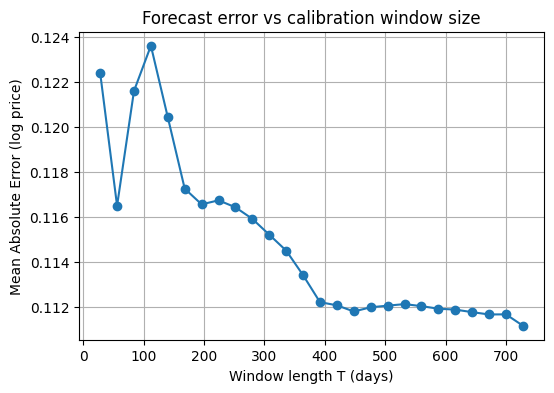

In [30]:
plt.figure(figsize=(6,4))
plt.plot(Win_T["T"], Win_T["MAE"], marker="o")
plt.xlabel("Window length T (days)")
plt.ylabel("Mean Absolute Error (log price)")
plt.title("Forecast error vs calibration window size")
plt.grid(True)
plt.show()

In [31]:
# Sets 
T_all = list(range(28, 729, 28))

set_defs = {
    "AW_all": T_all,
    "AW_short3": T_all[:3],
    "AW_short6": T_all[:6],
    "AW_long3": T_all[-3:],
    "AW_long6": T_all[-6:],
    "AW_mix6": T_all[:3] + T_all[-3:],
    "AW_mix8": T_all[:4] + T_all[-4:],
    "AW_mid3": [336, 364, 392],
    "AW_mid5": [308, 336, 364, 392, 420],
}

# Iteracyjne zestawy symetryczne
S_sizes = [2, 4, 6, 8, 10, 12]
for s in S_sizes:
    half = s // 2
    left = T_all[:half]
    right = T_all[-half:]
    set_defs[f"AW_S{s}"] = left + right

pred_dict = {r["T"]: r["Predictions"] for r in results}

In [35]:
def compute_aw_mae(Tset, name, y_true):
    preds_list = [pred_dict[T] for T in Tset if T in pred_dict]
    if len(preds_list) == 0:
        return {"Name": name, "Size": 0, "MAE": np.nan}
    
    preds_aw = np.nanmean(np.vstack(preds_list), axis=0)
    mask = ~np.isnan(preds_aw) & ~np.isnan(y_true)
    mae = np.mean(np.abs(y_true[mask] - preds_aw[mask]))

    return {"Name": name, "Size": len(Tset), "MAE": mae, "Tset": Tset}

In [ ]:
aw = []
for name, Tset in set_defs.items():
    results_aw_mae = compute_aw_mae(Tset, name, y_true_log)
    aw.append(results_aw_mae)

AW = pd.DataFrame(aw).sort_values("MAE").reset_index(drop=True)

In [ ]:
Win_T

,T,MAE
0,28,0.122392
1,56,0.116481
2,84,0.121588
3,112,0.123600
4,140,0.120419
5,168,0.117243
6,196,0.116544
7,224,0.116723
8,252,0.116414
9,280,0.115898


In [22]:
AW

,Name,Size,MAE,Tset
0,AW_S4,4,0.105236,"[28, 56, 700, 728]"
1,AW_S2,2,0.106005,"[28, 728]"
2,AW_mix6,6,0.106301,"[28, 56, 84, 672, 700, 728]"
3,AW_S6,6,0.106301,"[28, 56, 84, 672, 700, 728]"
4,AW_mix8,8,0.107431,"[28, 56, 84, 112, 644, 672, 700, 728]"
5,AW_S8,8,0.107431,"[28, 56, 84, 112, 644, 672, 700, 728]"
6,AW_S10,10,0.108012,"[28, 56, 84, 112, 140, 616, 644, 672, 700, 728]"
7,AW_S12,12,0.108262,"[28, 56, 84, 112, 140, 168, 588, 616, 644, 672..."
8,AW_all,26,0.109545,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280..."
9,AW_long3,3,0.111449,"[672, 700, 728]"


In [ ]:
baseline = Win_T[Win_T["T"] == 728] 
baseline_mae = baseline["MAE"].values[0]
delta_vs_win728 = []

for mae in AW["MAE"]: 
    delta = np.log(baseline_mae/mae)

    delta_vs_win728.append(delta)

AW["Delta_vs_Win728"] = delta_vs_win728
AW.sort_values("Delta_vs_Win728")

,Name,Size,MAE,Tset,Delta_vs_Win728
14,AW_short3,3,0.113278,"[28, 56, 84]",-0.019000
13,AW_mid3,3,0.113211,"[336, 364, 392]",-0.018407
12,AW_mid5,5,0.113104,"[308, 336, 364, 392, 420]",-0.017460
11,AW_short6,6,0.112480,"[28, 56, 84, 112, 140, 168]",-0.011934
10,AW_long6,6,0.111541,"[588, 616, 644, 672, 700, 728]",-0.003550
9,AW_long3,3,0.111449,"[672, 700, 728]",-0.002726
8,AW_all,26,0.109545,"[28, 56, 84, 112, 140, 168, 196, 224, 252, 280...",0.014509
7,AW_S12,12,0.108262,"[28, 56, 84, 112, 140, 168, 588, 616, 644, 672...",0.026291
6,AW_S10,10,0.108012,"[28, 56, 84, 112, 140, 616, 644, 672, 700, 728]",0.028606
4,AW_mix8,8,0.107431,"[28, 56, 84, 112, 644, 672, 700, 728]",0.033999
